### Summary of Notebook
- This program is executed after the Pre-Processing(Pre-Processing_Data.ipynb) on the data is complete.
- In this program we will build the model , train the model and log results.
- What we are going to build is a model that is capable of detecting a bounding box on the image -i.e object localisation
- We will try 3 different variants of the model
- We will build a Convolution Neural Network from SCRATCH ,train it & capture results.
- We will try a model that is iage classifier converted into an object detector i.e a pre-trained MobileNet base with a basic top layer re-built,re-trained and log results
- We will then try a model with pre-trained MobileNet base and a slightly more sophisticated  top layer re-built,retrained and log results 
- At the end of this program , we will have trained model with scores logged for all the different models tried and tested

In [ ]:
# Import Genereal libs  libraries

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import statistics as stats
sns.set(color_codes=True)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#Last import allows multiple outputs from one cell
import warnings
# Initialize the random number generator
import pickle
import random
random.seed(101)
# Import project specific libs
import tarfile
import os
import matplotlib.image as img
import cv2
import matplotlib.patches as patches
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet import MobileNet
from keras.models import Model,load_model
from keras.layers import Conv2D, Reshape,Flatten,Dense,Dropout,MaxPooling2D ,Input
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet import preprocess_input


In [ ]:
print(tf.__version__)

2.11.0


In [ ]:
# Useful Configuration/Setting

# suppress display of warnings
warnings.filterwarnings('ignore')

# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

#Setting to shows all entries in array displayed
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define evaluation metric

def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection
    # rk - again to repeat we know why he has minues , taken 2 times 

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tf.keras.backend.epsilon()), 4)# rounded to 4 
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou
    # this is one number for the whole model

def IoU(y_true, y_pred):
    iou = tf.py_function(IOU, [y_true, y_pred], Tout=tf.float32)
    return iou  
  # This is a wrapper funcction'''


In [ ]:
class Train_Util:
  #This Utility class performs EDA on the input data

  #Constructor func
 def __init__(self):
    self.imageFilepath="/content/drive/MyDrive/Object_Localisation/Data_Set/images/"
    self.ip_dataframe=pickle.load(open('/content/drive/MyDrive/Object_Localisation/Pickled_Data/IpDataFrame.pickle','rb'))
    print("# Shape #")
    # Add a filename extension
    self.ip_dataframe['filename']=self.ip_dataframe['image_name'] +'.jpg'
    print(self.ip_dataframe.shape)
    print("##########################################################################")
    #print("# Sample Records #")
    #print(self.ip_dataframe.sample(5))
    #print("##########################################################################")
    #print("# First 5  Records #")
    #print(self.ip_dataframe.head(5))
    #print("##########################################################################")
    self.rowSize=self.ip_dataframe.shape[0]
    #image length and width we desire
    self.expImageLength=256
    self.expImageWidth=256
    #Load Train and Test Tensors
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Train.npy')):
      self.X_Train=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Train.npy')
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Train_RegLabel.npy')):
      self.Y_Train_RegLabel=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Train_RegLabel.npy')

    #Check if pickled Test tensors already exist as part of the previously executed run of the program
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Test.npy')):
      self.X_Test=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/X_Test.npy')
    if(os.path.isfile('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Test_RegLabel.npy')):
      self.Y_Test_RegLabel=np.load('/content/drive/MyDrive/Object_Localisation/Pickled_Data/Y_Test_RegLabel.npy')
    return

 def modelPreprocDataForMobileNet(self):
    #Perform the necessary pre-processing for the model
    for index,eachRowData in enumerate(self.X_Train):
     self.X_Train[index]=preprocess_input(self.X_Train[index]) 
    for index,eachRowData in enumerate(self.X_Test):
     self.X_Test[index]=preprocess_input(self.X_Test[index]) 
    return


 def buildMultiTopLayerModel(self):
    #Build the model
    ALPHA = 1.0
    regODModel = MobileNet(input_shape=(self.expImageLength,self.expImageWidth,3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in regODModel.layers:
        layer.trainable = False
    # Add new top layer for Regression Head
    boxPredicModel= regODModel.layers[-1].output
    boxPredicModel= Flatten()(boxPredicModel)
    boxPredicModel= Dense(128,activation='relu')(boxPredicModel)
    boxPredicModel= Dropout(0.3)(boxPredicModel)
    #boxPredicModel= Dense(64,activation='relu')(boxPredicModel)
    #boxPredicModel= Dropout(0.3)(boxPredicModel)
    boxPredicModel = Dense(units=4)(boxPredicModel) # These are the 4 predicted coordinates of one BBox
    self.model= Model(inputs=regODModel.input, outputs=boxPredicModel,name="box_output")
    return 

 def buildSingleTopLayerModel(self):
    #Build the model
    ALPHA = 1.0
    regODModel = MobileNet(input_shape=(self.expImageLength,self.expImageWidth,3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in regODModel.layers:
        layer.trainable = False
    # Add new top layer for Regression Head
    boxPredicModel= regODModel.layers[-1].output
    boxPredicModel= Flatten()(boxPredicModel)
    boxPredicModel = Dense(units=4)(boxPredicModel) # These are the 4 predicted coordinates of one BBox
    self.model= Model(inputs=regODModel.input, outputs=boxPredicModel,name="box_output")
    return 
  
 def preprocDataForModelFromScratch(self):
   self.X_Train=self.X_Train/255.0
   self.X_Test=self.X_Test/255.0
   return



 def buildModelFromScratch(self):
    #NTS: Try this model also , & check results
    regODModel = Input(shape = (self.expImageLength, self.expImageWidth, 3))
    conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(regODModel)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(63, (3, 3), padding = 'same', activation = 'relu')(pool2)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(pool3)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(pool4)
    pool5 = MaxPooling2D(pool_size = (2, 2))(conv5)

    conv6 = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(pool5)
    pool6 = MaxPooling2D(pool_size = (2, 2))(conv6)

    flatten = Flatten()(pool6)
    dense1 = Dense(128, activation = 'relu')(flatten)
    drop1  = Dropout(0.5)(dense1)
    boxPredicModel = Dense(4)(drop1)

    self.model=Model(inputs=regODModel, outputs=boxPredicModel,name="box_output")
    return
    

 def trainModel(self):
    self.model.summary() # Print summary
    # Use earlystopping
    callback = EarlyStopping(monitor='val_IoU', patience=30, min_delta=0.01)
    mc = ModelCheckpoint('/content/drive/MyDrive/Object_Localisation/Pickled_Data/RegODModel_bestWieghts.h5', monitor='val_IoU', mode='max', verbose=1, save_best_only=True,save_weights_only=True)
    # If val_iou does not increase by 001 in 5 epochs , stop
    self.model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE
    # Fit the model
    self.model.fit(self.X_Train,self.Y_Train_RegLabel, validation_data=(self.X_Test,self.Y_Test_RegLabel), epochs=30,batch_size=32,callbacks=[callback,mc])
    return

 def runInference(self):
    #Load the best model
    self.model.load_weights('/content/drive/MyDrive/Object_Localisation/Pickled_Data/RegODModel_bestWieghts.h5')
    #we have to compile model, rememebr we recreated with saved weights , so its not the old model which was already compiled
    self.model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

    print(self.model.evaluate(self.X_Test,self.Y_Test_RegLabel))
    #Lets pick a sample from Test
    preProcTestImage= preprocess_input(self.X_Test[701])

    #Note here model expects shape expected shape=(None, 256, 256, 3)and we are giving found shape=(256, 256, 3)
    # So we must reshape
    #Looks like for training we didnt do because mobile net pre-proc lib takes care of reshaping
    bbregion=self.model.predict(preProcTestImage.reshape(1,256,256,3))

    # Lets view same sample PREDICTION
    im=self.X_Test[701]
    # Show resized image with Box
    #fig,ax = plt.subplots(1)
    fig = plt.figure(figsize=(7,7))
    ax=plt.subplot(1,1,1)
    ax.imshow(im)
    res_x0=bbregion[0][0]
    res_y0=bbregion[0][1]
    res_x1=bbregion[0][2]
    res_y1=bbregion[0][3]
    rect = patches.Rectangle((res_x0, res_y0), res_x1 - res_x0, res_y1 - res_y0, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    return


In [ ]:
if __name__ == "__main__":
  # Build Model with base MobileNet and basic top layer
  objPreproc= Train_Util()
  objPreproc.modelPreprocDataForMobileNet()  
  objPreproc.buildSingleTopLayerModel()
  objPreproc.trainModel()

# Shape #
(3671, 13)
##########################################################################


17225924/17225924 [==============================] - 0s 0us/step
Model: "box_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     12

In [ ]:
if __name__ == "__main__":
  # Build Model with base MobileNet and basic top layer
  objPreproc= Train_Util()
  objPreproc.modelPreprocDataForMobileNet()  
  objPreproc.buildMultiTopLayerModel()
  objPreproc.trainModel()

# Shape #
(3671, 13)
##########################################################################


Model: "box_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                                 

In [ ]:
if __name__ == "__main__":
  # Build Model with base MobileNet and basic top layer
  objPreproc= Train_Util()
  objPreproc.preprocDataForModelFromScratch() #Does normalization
  #Without Normalisation(pre-processsing) val_IoU was 0.62501
  objPreproc.buildModelFromScratch()
  objPreproc.trainModel()

# Shape #
(3671, 13)
##########################################################################
Model: "box_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                          

# Shape #
(3671, 13)
##########################################################################


35/35 [==============================] - 10s 261ms/step - loss: 2770.4492 - IoU: 0.2666
[2770.44921875, 0.2665971517562866]
1/1 [==============================] - 0s 462ms/step


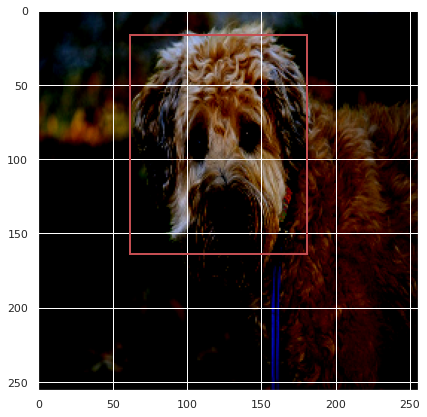

In [ ]:
# Run an inference on the best model obtained  

if __name__ == "__main__":
  objPreproc= Train_Util()
  objPreproc.buildSingleTopLayerModel()
  # loads best weights and runs model
  objPreproc.runInference()

### Result
- 3 Different models were tried to build the regression head/ bounding box
- A model with pre-trained mobile Net base with a basic top layer reconstructed gave the best results of validation IOU of .96 in 30 epochs
- A model with pre-trained mobile Net base with a more complex top layer reconstructed gave us a result of .8372 in 30 epochs . Further training could possible give us hihger numbers
- A 6 layer deep CNN model built from scratch gave us a result of .5295 in 30 epochs . Further training could possible give us higher numbers.
- The best model is model no 1( model with pre-trained mobile Net base with a basic top layer reconstructed)